# Generating model spectra

Spectuner implements the one-dimensional LTE spectral model, which is introduced in the [user guide](../guide/sl_model.rst). As a basic functionality, this tutorial demonstrates how to generate model spectra.

Set ``fname_db`` below to the path of the CDMS database file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spectuner

fname_db = "path/to/the/cdms/database"

## Generating model spectra of one molecule

To gnerate model spectra, we need to specify the frequency range and the beam size of the observation. The latter is used to compute the beam filling factor. After the configuration, we should create a [SpectralLineModelFactory](../api/slm_factory.rst#spectuner.slm_factory.SpectralLineModelFactory) instance, which is the primary interface to create callable objects for generating model spectra. 

In [2]:
config = spectuner.load_default_config()

config.set_fname_db(fname_db)

freq = np.linspace(220200., 220850, 10000) # MHz
beam_info = (1./3600, 1./3600) # deg
config.append_spectral_window_simple(freq, beam_info)

slm_factory = spectuner.SpectralLineModelFactory(config)

The next step is to specify the molecule of the spectral line model and then create the callable.

In [3]:
specie_list = spectuner.create_specie_list("CH3CN;v=0;")
sl_model = slm_factory.create_sl_model(config["obs_info"], specie_list)

As described in [user guide](../guide/sl_model.rst), the spectral line model has five parameters. By default, they should in the following order and units:

- ``theta``: Source size in arcsec.
- ``T_ex``: Excitation temperature in K.
- ``N_tot``: Column density in cm^-2. This parameter is in log scale by default.
- ``delta_v``: Velocity width in km/s.
- ``v_offset``: Velocity offset in km/s.

As an example, ``params`` below means ``(theta = 1.0 arcsec, T_ex = 100 K, N_tot = 10^16 cm^-2, delta_v = 5 km/s, v_offset =-1 km/s)``.

Since we often work with multiple spectral windows, ``sl_model`` returns a list, with each element being the spectrum of a spectral window.

In [4]:
params = np.array([1., 100., 16., 5., -1.])
T_pred_data = sl_model(params)

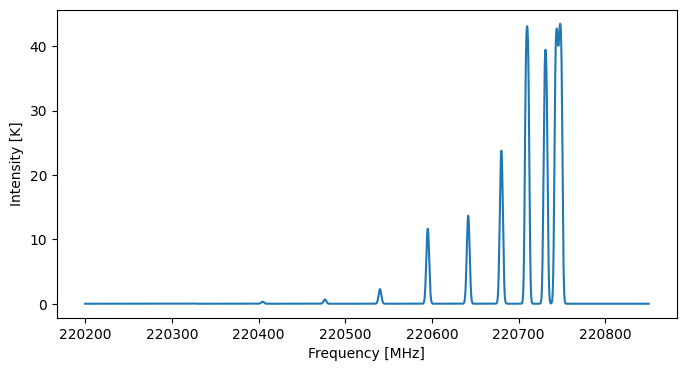

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(freq, T_pred_data[0])

ax.set_ylabel("Intensity [K]")
ax.set_xlabel("Frequency [MHz]");

## Generating model spectra of multiple molecules with shared parameters

Spectuner allows to compute spectra of multiple molecules with shared parameters. We may use [set_param_info](../api/config.rst#spectuner.config.Config.set_param_info) to specify the shared parameters. The code block below gives an example of computing spectra of CH3CN and C2H5CN with a shared velocity offset. In addition, the model sums the spectra of all molecules linearly.

In [6]:
config = spectuner.load_default_config()

config.set_fname_db(fname_db)

freq = np.linspace(220200., 220850, 10000) # MHz
beam_info = (1./3600, 1./3600) # deg
config.append_spectral_window_simple(freq, beam_info)

# Set shared parameters
config.set_param_info("v_offset", is_log=False, is_shared=True)

slm_factory = spectuner.SpectralLineModelFactory(config)

specie_list = spectuner.create_specie_list("CH3CN;v=0;", "C2H5CN;v=0;")
sl_model = slm_factory.create_sl_model(config["obs_info"], specie_list)

The shared parameters should be given before the independent parameters. As an example, ``params`` below indicates:

- ``(theta = 1.0 arcsec, T_ex = 100 K, N_tot = 10^16 cm^-2, delta_v = 5 km/s, v_offset =-1 km/s)`` for ``CH3CN;v=0;``.
- ``(theta = 1.0 arcsec, T_ex = 300 K, N_tot = 10^17 cm^-2, delta_v = 4 km/s, v_offset =-1 km/s)`` for ``C2H5CN;v=0;``.

In [7]:
params = np.array([-1., 1., 1., 100, 300, 16, 17, 5., 4.])
T_pred_data = sl_model(params)
T_dict = sl_model.compute_individual_spectra(params)

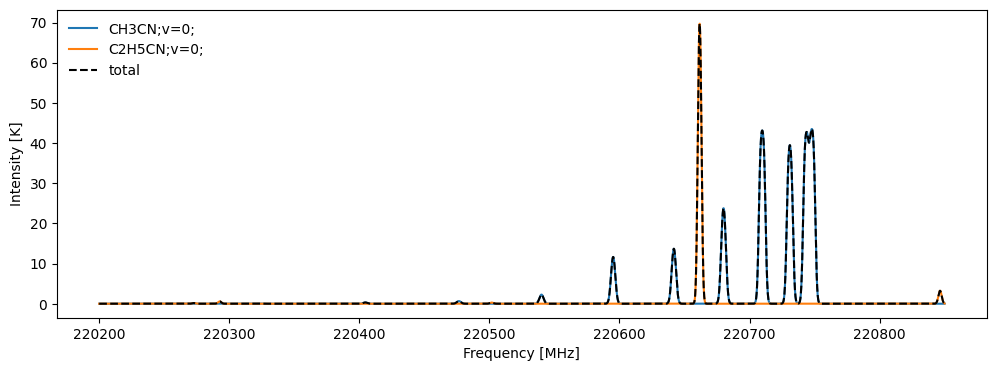

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))


for key, T_data in T_dict.items():
    ax.plot(freq, T_data[0], label=key)
ax.plot(freq, T_pred_data[0], "k--", label="total")

ax.legend(frameon=False, loc="upper left")

ax.set_ylabel("Intensity [K]")
ax.set_xlabel("Frequency [MHz]");